In [1]:
!pip install transformers
!pip install shap
!pip install spicy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 9.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import transformers
import shap
import spicy as sp
from transformers import AutoModel, AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.utils import data
from sklearn import metrics
import torch.nn as nn
import pandas as pd
import numpy as np
import argparse
import logging
import random
import torch
import sys
import os

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
PREDICTION_COLUMN = 'Нейротизм_3'
model_path = '/content/drive/MyDrive/big_5/OCEAN_shap_texts_bert/simple_bert_Нейротизм_3_43375.bin'

dataset = pd.read_csv('/content/drive/MyDrive/big_5/df_texts_ocean.csv')
dataset['lengths'] = dataset.post_text.apply(lambda x: len(str(x).split()))
dataset = dataset.query('30 > lengths > 15')
data = pd.DataFrame({'text':dataset['post_text_preprocessed'],'target':dataset[PREDICTION_COLUMN]})
data = data.query('target in [0,2]').sample(5000)
data.head()

,text,target
161596,я только что сказал PUNK что я думаю о юлия ол...,2
220334,боже PUNK дай мудрости PUNK чтобы понять мужчи...,2
28118,PUNK star PUNK struck PUNK дочке пятый год PU...,2
154821,выдаю займы участникам соц сетей на срок до NU...,2
61561,папа PUNK может мну тож в криушу махнуть PUNK ...,2


In [18]:
data.target.value_counts()

2    3227
0    1773
Name: target, dtype: int64

In [19]:
len(data)

5000

In [7]:
class Bert_sequence_classifcation(nn.Module):
    def __init__(self, model_name, num_classes):
        super(Bert_sequence_classifcation, self).__init__()
        self.bert = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=num_classes)

    def forward(self, input_ids, attention_mask):
        # Feed input to BERT
        logits = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask, return_dict=True).logits 
        return logits

In [8]:
 # load the model and tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained('xlm-roberta-base')
model = Bert_sequence_classifcation('xlm-roberta-base', 3).to(device)
model.load_state_dict(torch.load(model_path))   #,map_location=torch.device('cpu')))
labels = sorted(model.bert.config.label2id, key=model.bert.config.label2id.get)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

In [9]:
def f(x):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # print(x)
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=100, truncation=True) for v in x], device=device)
    # print(tv)
    attention_mask = (tv != 0).type(torch.int64)
    # print(attention_mask)
    outputs = model(tv, attention_mask).detach().cpu()
    outputs = torch.log_softmax(outputs, dim=1).numpy()
    # print(outputs)
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores)
    return val

In [10]:
def predict(x):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # print(x)
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=100, truncation=True) for v in x], device=device)
    # print(tv)
    attention_mask = (tv != 0).type(torch.int64).to(device)
    # print(attention_mask)
    outputs = model(tv, attention_mask).detach().cpu()
    res = torch.log_softmax(outputs, dim=1).argmax(dim=1)
    return res

In [11]:
predict(['приветик','еще раз привет'])

tensor([1, 1])

In [20]:
texts = list(data.text)
targets = list(data.target)

def chunkify(texts, targets, n):

  texts_splited = [texts[i::n] for i in range(n)]
  targets_splited = [targets[i::n] for i in range(n)]

  return texts_splited, targets_splited

texts_splited, targets_splited =chunkify(texts, targets, 50)

In [21]:
len(texts_splited[0])

100

In [26]:
from tqdm.auto import tqdm

In [27]:
predictions = []
for text in tqdm(texts_splited):
  predictions.append(predict(text))

  0%|          | 0/50 [00:00<?, ?it/s]

In [31]:
list_predictions = []
for i in predictions:
  for x in list(i):
    list_predictions.append(int(x))

In [33]:
len(list_predictions)

5000

In [35]:
data['predictions'] = list_predictions
data.head()

,text,target,predictions
161596,я только что сказал PUNK что я думаю о юлия ол...,2,1
220334,боже PUNK дай мудрости PUNK чтобы понять мужчи...,2,1
28118,PUNK star PUNK struck PUNK дочке пятый год PU...,2,2
154821,выдаю займы участникам соц сетей на срок до NU...,2,2
61561,папа PUNK может мну тож в криушу махнуть PUNK ...,2,2


In [36]:
polar_people = data.query('target == predictions')
polar_people

,text,target,predictions
28118,PUNK star PUNK struck PUNK дочке пятый год PU...,2,2
154821,выдаю займы участникам соц сетей на срок до NU...,2,2
61561,папа PUNK может мну тож в криушу махнуть PUNK ...,2,2
81918,наивные как дети PUNK опасные как волки PUNK м...,0,0
116854,по пути к дому мечтаешь о новых свершениях PUN...,2,2
...,...,...,...
242630,PUNK eight PUNK spoked asterisk PUNK перейти ...,0,0
177816,мне нужен картон PUNK чтобы зажечь костер PUNK...,2,2
16453,ой PUNK спасибочки за рисунок EMOJI PUNK я уж ...,2,2
176489,мне нужны стеклоочистители PUNK чтобы очистить...,2,2


In [37]:
import shap
explainer = shap.Explainer(f, tokenizer, output_names=labels)

In [38]:
texts = list(polar_people.text)
shap_values = explainer(texts)

Partition explainer:   8%|▊         | 106/1332 [05:29<1:05:19,  3.20s/it]Token indices sequence length is longer than the specified maximum sequence length for this model (1872 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  93%|█████████▎| 1245/1332 [1:06:14<04:38,  3.20s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 1333it [1:11:10,  3.21s/it]


In [43]:
shap.plots.text(shap_values[:10])

Output hidden; open in https://colab.research.google.com to view.

In [44]:
shap.plots.text(shap_values[10:20])

Output hidden; open in https://colab.research.google.com to view.

In [45]:
shap.plots.text(shap_values[20:30])

Output hidden; open in https://colab.research.google.com to view.

In [46]:
shap.plots.text(shap_values[30:40])

Output hidden; open in https://colab.research.google.com to view.

In [47]:
shap.plots.text(shap_values[40:50])

Output hidden; open in https://colab.research.google.com to view.

In [48]:
shap.plots.text(shap_values[50:60])

Output hidden; open in https://colab.research.google.com to view.

In [49]:
shap.plots.text(shap_values[60:70])

Output hidden; open in https://colab.research.google.com to view.

In [50]:
shap.plots.text(shap_values[70:80])

Output hidden; open in https://colab.research.google.com to view.

In [51]:
shap.plots.text(shap_values[80:90])

Output hidden; open in https://colab.research.google.com to view.

In [52]:
shap.plots.text(shap_values[90:100])

Output hidden; open in https://colab.research.google.com to view.

In [53]:
shap.plots.text(shap_values[100:120])

Output hidden; open in https://colab.research.google.com to view.

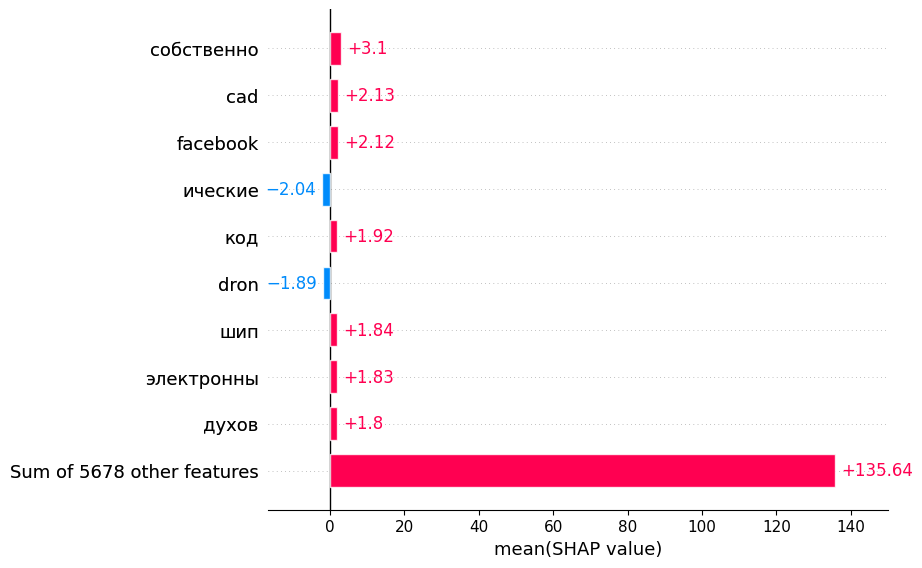

In [54]:
shap.plots.bar(shap_values[:,:,0].mean(0)) # по классу 0

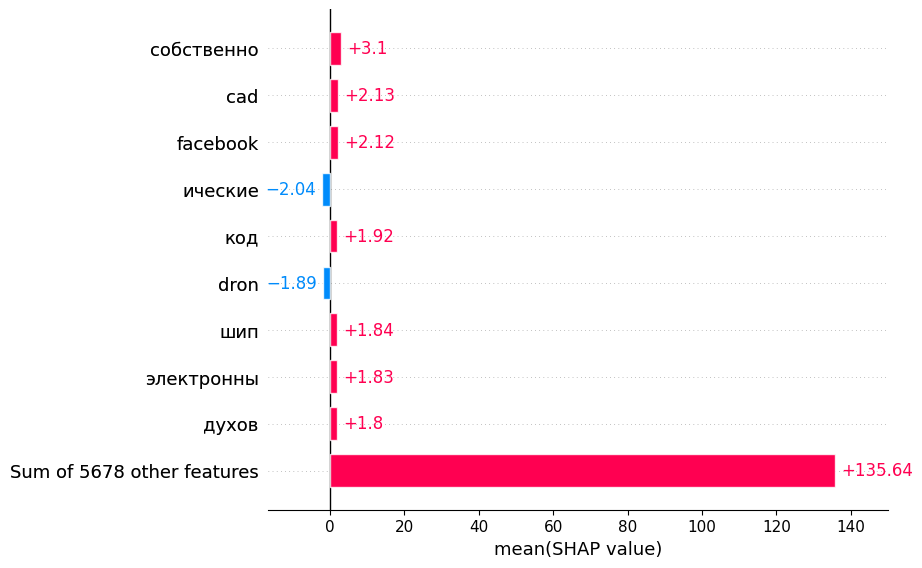

In [57]:
shap.plots.bar(shap_values[:,:,0].mean(0)) 

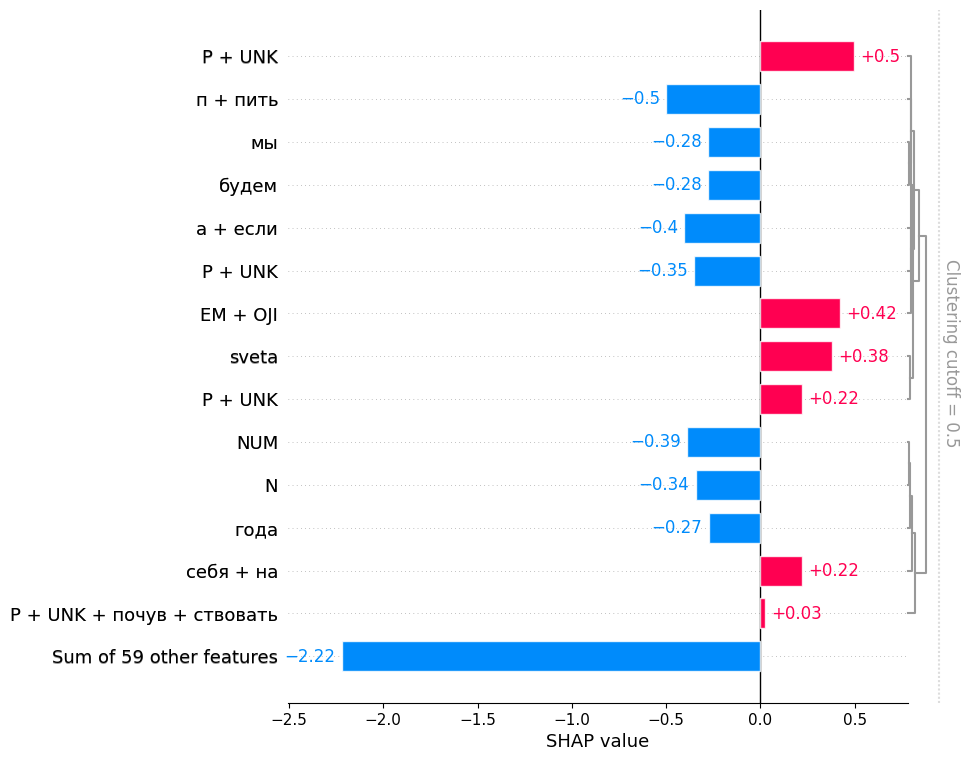

In [60]:
shap.plots.bar(shap_values[2,:, 2], max_display=15,
               order=shap.Explanation.argsort.flip) # 4  это класс

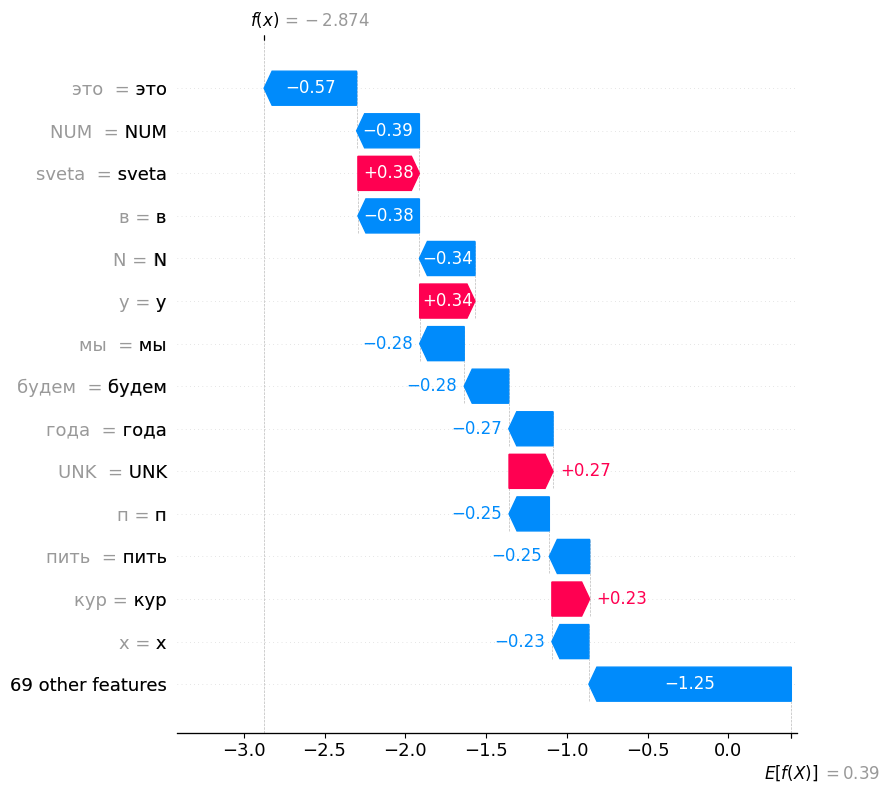

In [61]:
shap.waterfall_plot(shap_values[2][:, 2], max_display=15)